In [9]:
import os

def git_get():
    '''Get latest version from github'''
    os.system("git remote update")
    os.system("git pull")
    
def git_put(message):
    '''Adds/commits this notebook'''
    os.system("git add ML_projekt1.ipynb")
    os.system('git commit -m "{}"'.format(message))
    os.system("git push")

# Project starts here

In [1]:
%matplotlib inline 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

## Analysis goals

The ultimate goal for this dataanalysis is to determine which features make a movie "successful". The definition of "successful" is of course a bit vague, but during this dataanalysis we will define success as high popularity and/or gross revenue.

In our initial dataanalysis we will use regression to detemine if there is a correlation between IMDB score and revenue.

## Initial hypothesis and assumptions

Based on intuition we expect that more popular movies in general generate a bigger revenue, since we assume popularity is highly correlated with the total number of consumers for that specific movie.



## Method of analysis

This analysis uses the OSEMN model.<br><br>
https://machinelearningmastery.com/how-to-work-through-a-problem-like-a-data-scientist/

# 1. Obtain Data

## Dataset source and description

The IMDB Movie dataset from Kaggle.com, contains information from 5000 movies, obtained by webscraping IMDB.com. Note that the dataset has recently been removed from Kaggle and replaces with a new dataset which is not compliant with this notebook. Kaggle hosts a multitude of "kernels" (runable data science papers), with titles such as: "film recommendation engine", "Movie Recommendations" and "Categorizing actors".

https://www.kaggle.com/tmdb/tmdb-movie-metadata/data


# 2. Scrub Data

# Data preparation, cleaning and structure

Throughout this analysis we will handle the dataset in a dictionary named "data". It is the hope of the authors that this structure will make code-snippets more readable and remove the need for redundant comment/explanations (this paragraph excluded).

In [4]:
data = {}
data['raw'] = pd.read_csv("movie_metadata.csv")
data['no_na'] = data['raw'].dropna();
data['n_removed_na'] = data['raw'].shape[0] - data['no_na'].shape[0]
print(f"Number of removed rows: {data['n_removed_na']} out of {data['raw'].shape[0]}")

Number of removed rows: 1287 out of 5043


## Post-cleaning data validation

As indicated above, many rows containing N/A-data was removed from the dataset. It is acknowledged by the authors that may reduce the prediction generalizability, but at the time of writing this decision seems justifiable in comparisson to potentially mishandling N/A's.

# 3. Explore Data

## Summary statistics

A summary of the statistics are given below, including the mean, standard deviation, and the different quartiles for each attribute. These values will be relevant later, when interpreting results.

In [3]:
data['no_na'].describe().round(decimals=2)

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,3756.00,3756.00,3756.00,3756.00,3756.00,3.756000e+03,3756.00,3756.00,3756.00,3756.00,3.756000e+03,3756.00,3756.00,3756.00,3756.00,3756.00
mean,167.38,110.26,807.34,771.28,7751.34,5.261282e+07,105826.73,11527.10,1.38,336.84,4.623685e+07,2002.98,2021.78,6.47,2.11,9353.83
std,123.45,22.65,3068.17,1894.25,15519.34,7.031787e+07,152035.40,19122.18,2.04,411.23,2.260103e+08,9.89,4544.91,1.06,0.35,21462.89
min,2.00,37.00,0.00,0.00,0.00,1.620000e+02,91.00,0.00,0.00,4.00,2.180000e+02,1927.00,0.00,1.60,1.18,0.00
25%,77.00,96.00,11.00,194.00,745.00,8.270233e+06,19667.00,1919.75,0.00,110.00,1.000000e+07,1999.00,384.75,5.90,1.85,0.00
50%,138.50,106.00,64.00,436.00,1000.00,3.009311e+07,53973.50,4059.50,1.00,210.00,2.500000e+07,2004.00,685.50,6.60,2.35,227.00
75%,224.00,120.00,235.00,691.00,13000.00,6.688194e+07,128602.00,16240.00,2.00,398.25,5.000000e+07,2010.00,976.00,7.20,2.35,11000.00
max,813.00,330.00,23000.00,23000.00,640000.00,7.605058e+08,1689764.00,656730.00,43.00,5060.00,1.221550e+10,2016.00,137000.00,9.30,16.00,349000.00


## Catagorical data

Identify number of columns with object data

In [13]:
data['raw'].dtypes.value_counts()

float64    13
object     12
int64       3
dtype: int64

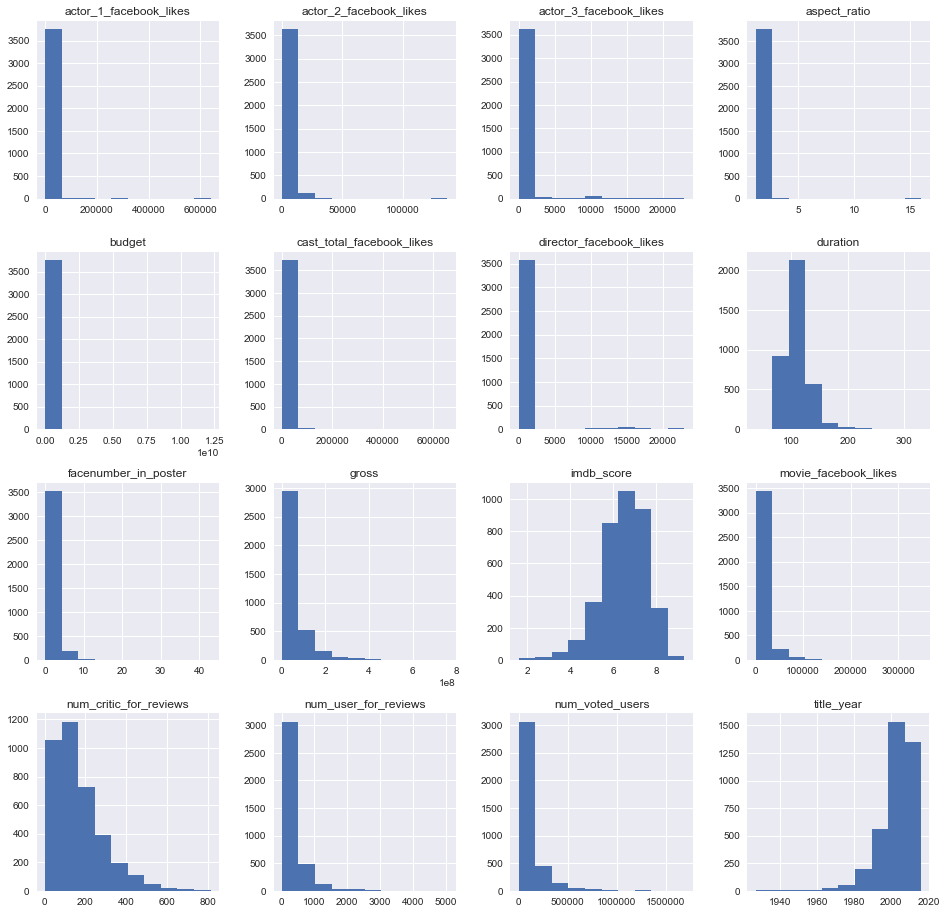

In [6]:
data['no_na'].hist(figsize=(16,16));

In the following table all the 28 different attributes are explained and it's shown whether they are discrete or continous together with their level of measurement.  


<table valign="left">
  <tr>
    <th>Attribute</th>
    <th>Explanation</th>
    <th>Discrete/continous</th>
    <th>Nominal/Ordinal/Interval/Ratio</th>
  </tr>
  <tr>
    <td>color</td>
    <td>Is the movie in color or black and white</td>
    <td>Discrete</td>
    <td>Nominal</td>
  </tr>
  <tr>
    <td>director_name</td>
    <td>Name of the director</td>
    <td>Discrete</td>
    <td>Nominal</td>
  </tr>
  <tr>
    <td>num_critic_for_reviews</td>
    <td>Number of critics reviews</td>
    <td>Discrete</td>
    <td>Ratio</td>
  </tr>
  <tr>
    <td>duration</td>
    <td>Duration of the movie</td>
    <td>Continous</td>
    <td>Ratio</td>
  </tr>
  <tr>
    <td>director_facebook_likes</td>
    <td>The directors amount of facebook likes</td>
    <td>Discrete</td>
    <td>Ratio</td>
  </tr>
  <tr>
    <td>actor_3_facebook_likes</td>
    <td>Third actor likes on Facebook</td>
    <td>Discrete</td>
    <td>Ratio</td>
  </tr>
  <tr>
    <td>actor_2_name</td>
    <td>Second actor's name</td>
    <td>Discrete</td>
    <td>Nominal</td>
  </tr>
  <tr>
    <td>actor_1_facebook_likes</td>
    <td>First actor likes on Facebook</td>
    <td>Discrete</td>
    <td>Ratio</td>
  </tr>
  <tr>
    <td>gross</td>
    <td>Gross income of the movie</td>
    <td>Continous</td>
    <td>Ratio</td>
  </tr>
  <tr>
    <td>genres</td>
    <td>The movies genre </td>
    <td>Discrete</td>
    <td>Nominal</td>
  </tr>
  <tr>
    <td>actor_1_name</td>
    <td>First actor's name</td>
    <td>Discrete</td>
    <td>Nominal</td>
  </tr>
  <tr>
    <td>movie_title</td>
    <td>Title of the movie</td>
    <td>Discrete</td>
    <td>Nominal</td>
  </tr>
  <tr>
    <td>num_voted_users</td>
    <td>Number of votes at IMDB</td>
    <td>Discrete</td>
    <td>Ratio</td>
  </tr>
  <tr>
    <td>cast_total_facebook_likes</td>
    <td>Total Facebook likes for the cast</td>
    <td>Discrete</td>
    <td>Ratio</td>
  </tr>
  <tr>
    <td>actor_3_name</td>
    <td>Third actor's name</td>
    <td>Discrete</td>
    <td>Nominal</td>
  </tr>
  <tr>
    <td>facenumber_in_poster</td>
    <td>Amount of faces in the poster</td>
    <td>Discrete</td>
    <td>Ratio</td>
  </tr>
  <tr>
    <td>plot_keywords</td>
    <td>Keyword related to movie plot</td>
    <td>Discrete</td>
    <td>Nominal</td>
  </tr>
  <tr>
    <td>movie_imdb_link</td>
    <td>The movies imdb link</td>
    <td>Discrete</td>
    <td>Nominal</td>
  </tr>
  <tr>
    <td>num_user_for_reviews</td>
    <td>Number of user reviews</td>
    <td>Discrete</td>
    <td>Ratio</td>
  </tr>
  <tr>
    <td>language</td>
    <td>Spoken language</td>
    <td>Discrete</td>
    <td>Nominal</td>
  </tr>
  <tr>
    <td>country</td>
    <td>Country of origin </td>
    <td>Discrete</td>
    <td>Nominal </td>
  </tr>
  <tr>
    <td>content_rating</td>
    <td>Content rating</td>
    <td>Discrete</td>
    <td>Nominal</td>
  </tr>
  <tr>
    <td>budget</td>
    <td>The budget of the movie</td>
    <td>Continous</td>
    <td>Ratio</td>
  </tr>
  <tr>
    <td>title_year</td>
    <td>Release date</td>
    <td>Discrete</td>
    <td>Interval</td>
  </tr>
  <tr>
    <td>actor_2_facebook_likes</td>
    <td>Second actor likes on Facebook</td>
    <td>Discrete</td>
    <td>Ratio</td>
  </tr>
  <tr>
    <td>imdb_score</td>
    <td>Score on imdb (voted by users)</td>
    <td>Discrete</td>
    <td>Ratio</td>
  </tr>
  <tr>
    <td>aspect_ratio</td>
    <td>Aspect ratio of the movie</td>
    <td>Discrete</td>
    <td>Nominal </td>
  </tr>
  <tr>
    <td>movie_facebook_likes</td>
    <td>Total Facebook likes of the movie</td>
    <td>Discrete</td>
    <td>Ratio</td>
  </tr>
</table>

By grouping the dataset features, we can select the correct machine learning strategy based on the table below.

<table>
  <tr>
    <th></th>
    <th>Supervised</th>
    <th>Unsupervised</th>
  </tr>
  <tr>
    <td>Continuous</td>
    <td>Regression</td>
    <td>Clustering</td>
  </tr>
  <tr>
    <td>Discrete</td>
    <td>Classification</td>
    <td>Association mining</td>
  </tr>
</table>

In the Principle Component Analysis we will ignore ALL catagorical data.

# Analysis

1. A description of your data set.
Explain
OK -- • What the problem of interest is (i.e. what is your data about),
OK -- • Where you obtained the data,
OK -- • What has previously been done to the data. (i.e. if available go through
some of the original source papers and read what they did to the data
and summarize what were their results).
Halvt-OK -- • What the primary machine learning modeling aim is for the data, i.e.
which attributes you feel are relevant when carrying out a classification,
a regression, a clustering, an association mining, and an anomaly detection
in the later reports and what you hope to accomplish using these
techniques. For instance, which attribute do you wish to explain in the
regression based on which other attributes? Which class label will you predict based on which other attributes in the classification task? If you need to transform the data to admit these tasks, explain roughly how you might do this (but don’t transform the data now!).


2. A detailed explanation of the attributes of the data.
OK -- • Describe if the attributes are discrete/continous, Nominal/Ordinal/Interval/Ratio,
OK -- • give an account of whether there are data issues (i.e. missing values or
corrupted data) and describe them if so
OK -- • describe the basic summary statistics of the attributes.
If your data set contains many similar attributes, you may restrict yourself to
describing a few representative features (apply common sense).


## Data visualization

3. Data visualization(s) based on suitable visualization techniques including
a principal component analysis (PCA).
Touch upon the following subjects, use visualizations when it appears sensible.
Keep in mind the ACCENT principles and Tufte’s guidelines when you visualize
the data.
Mangler --• Are there issues with outliers in the data,
OK -- • do the attributes appear to be normal distributed,
OK -- • are variables correlated,
Mangler --• does the primary machine learning modeling aim appear to be feasible
based on your visualizations.
There are three aspects that needs to be described when you carry out the
PCA analysis for the report:
OK -- • The amount of variation explained as a function of the number of PCA
components included,
OK -- • the principal directions of the considered PCA components (either find a
way to plot them or interpret them in terms of the features),
Mangler --• the data projected onto the considered principal components.
If your attributes have very different scales it may be relevant to standardize
the data prior to the PCA analysis.

# 4. Model Data

## Principle Component Analysis: Preprocessing

In our Principe Component Analysis we wish to reduce the number of dimensions in our dataset without losing too much of the data. In this method of analysis it is worth noting, that while we may be able to reduce the number of dimensions, these might not be easily, if at all, interpretable.

Before doing a Principle Component Analysis we wish to extract only numerical data our dataset as well as find eigenvalues and eigenvectors. From this information we can generate a visualization of the individual and cumulative variance explained by the eigenvectors. This will be important for determining a suitable number of components for our analysis.

In [17]:
data['numerical'] = data['no_na'].select_dtypes(exclude=['object']).fillna(value=0, axis=1)
data['X_std'] = StandardScaler().fit_transform(data['numerical'].values)
data['covariance'] = np.cov(data['X_std'].T)
data['eigenvalues'], data['eigenvectors'] = np.linalg.eig(data['covariance'])
data['eigenvalues_variance_explained'] = [(i/data['eigenvalues'].sum())*100 for i in sorted(data['eigenvalues'], reverse=True)]

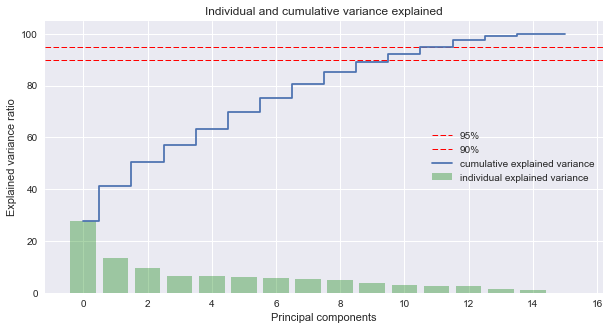

In [22]:
plt.figure(figsize=(10, 5))
plt.bar(range(16), data['eigenvalues_variance_explained'], alpha=0.3333, align='center', label='individual explained variance', color = 'g')
plt.axhline(y=95, linewidth=1, color='r', linestyle='dashed', label="95%")
plt.axhline(y=90, linewidth=1, color='r', linestyle='dashed', label="90%")
plt.step(range(16), np.cumsum(data['eigenvalues_variance_explained']), where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.title('Individual and cumulative variance explained')
plt.show()

(((PASSENDE TITEL)))

From this plot we can see that using 10 components, our model will be able to explain 90% - 95% of the total variance. So this looks promising for our analysis as we will be able to reduce our total dimensions from 16 to 10.

## Regression: Preprocessing

Create correlation matrix from numerical features. On this plot we hide the diagonal and upper half, and highlight all correlations above 0.5, or below -0.5.

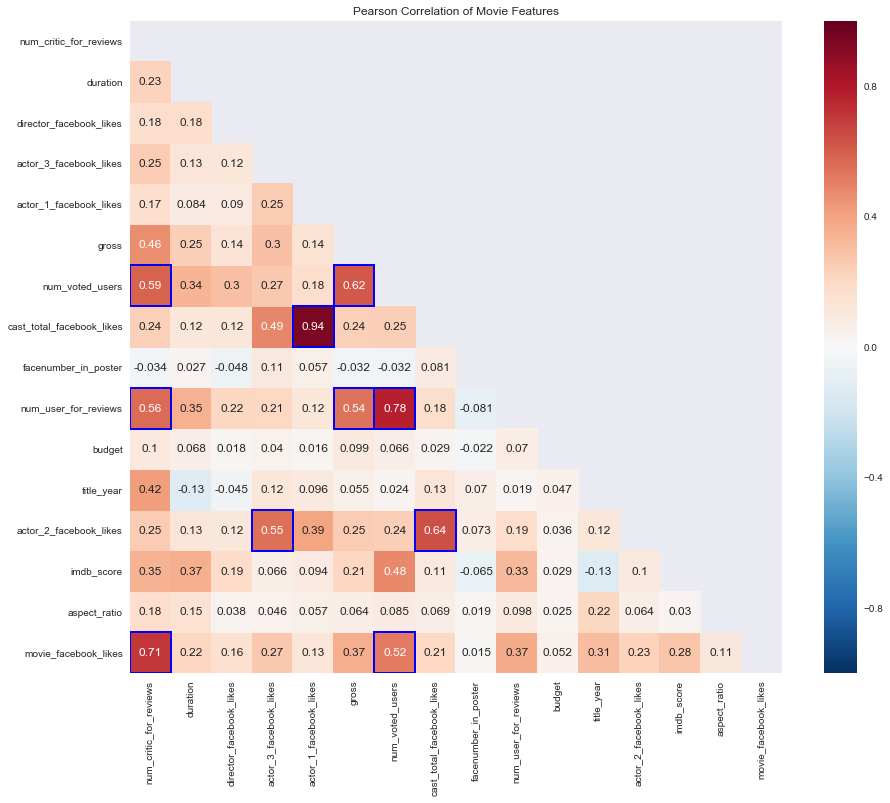

In [55]:
data['numerical_correlation'] = data['numerical'].corr()
plt.subplots(figsize=(15, 12))
plt.title('Pearson Correlation of Movie Features')

# Mask to remove diagonal and upper half
mask = np.zeros_like(data['numerical_correlation'], dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(data['numerical_correlation'],vmax=1,square=True,annot=True,mask=mask);


for cell in ax.texts:
    if (abs(float(cell.get_text())) > 0.5):
        ax.add_patch(Rectangle((int(cell.get_position()[0]-0.5), int(cell.get_position()[1]-0.5)), 1, 1, fill=False, edgecolor='blue', lw=2))

plt.show()

From our correlation matrix (heatmap), we can see some surprising correlations. Imdb_score and budget do not seem to correlate with anything.

## PCA## Principle Component Analysis: Preprocessing

In [56]:
pca = PCA(n_components=10)
data['PCA10'] = pca.fit_transform(data['X_std'])

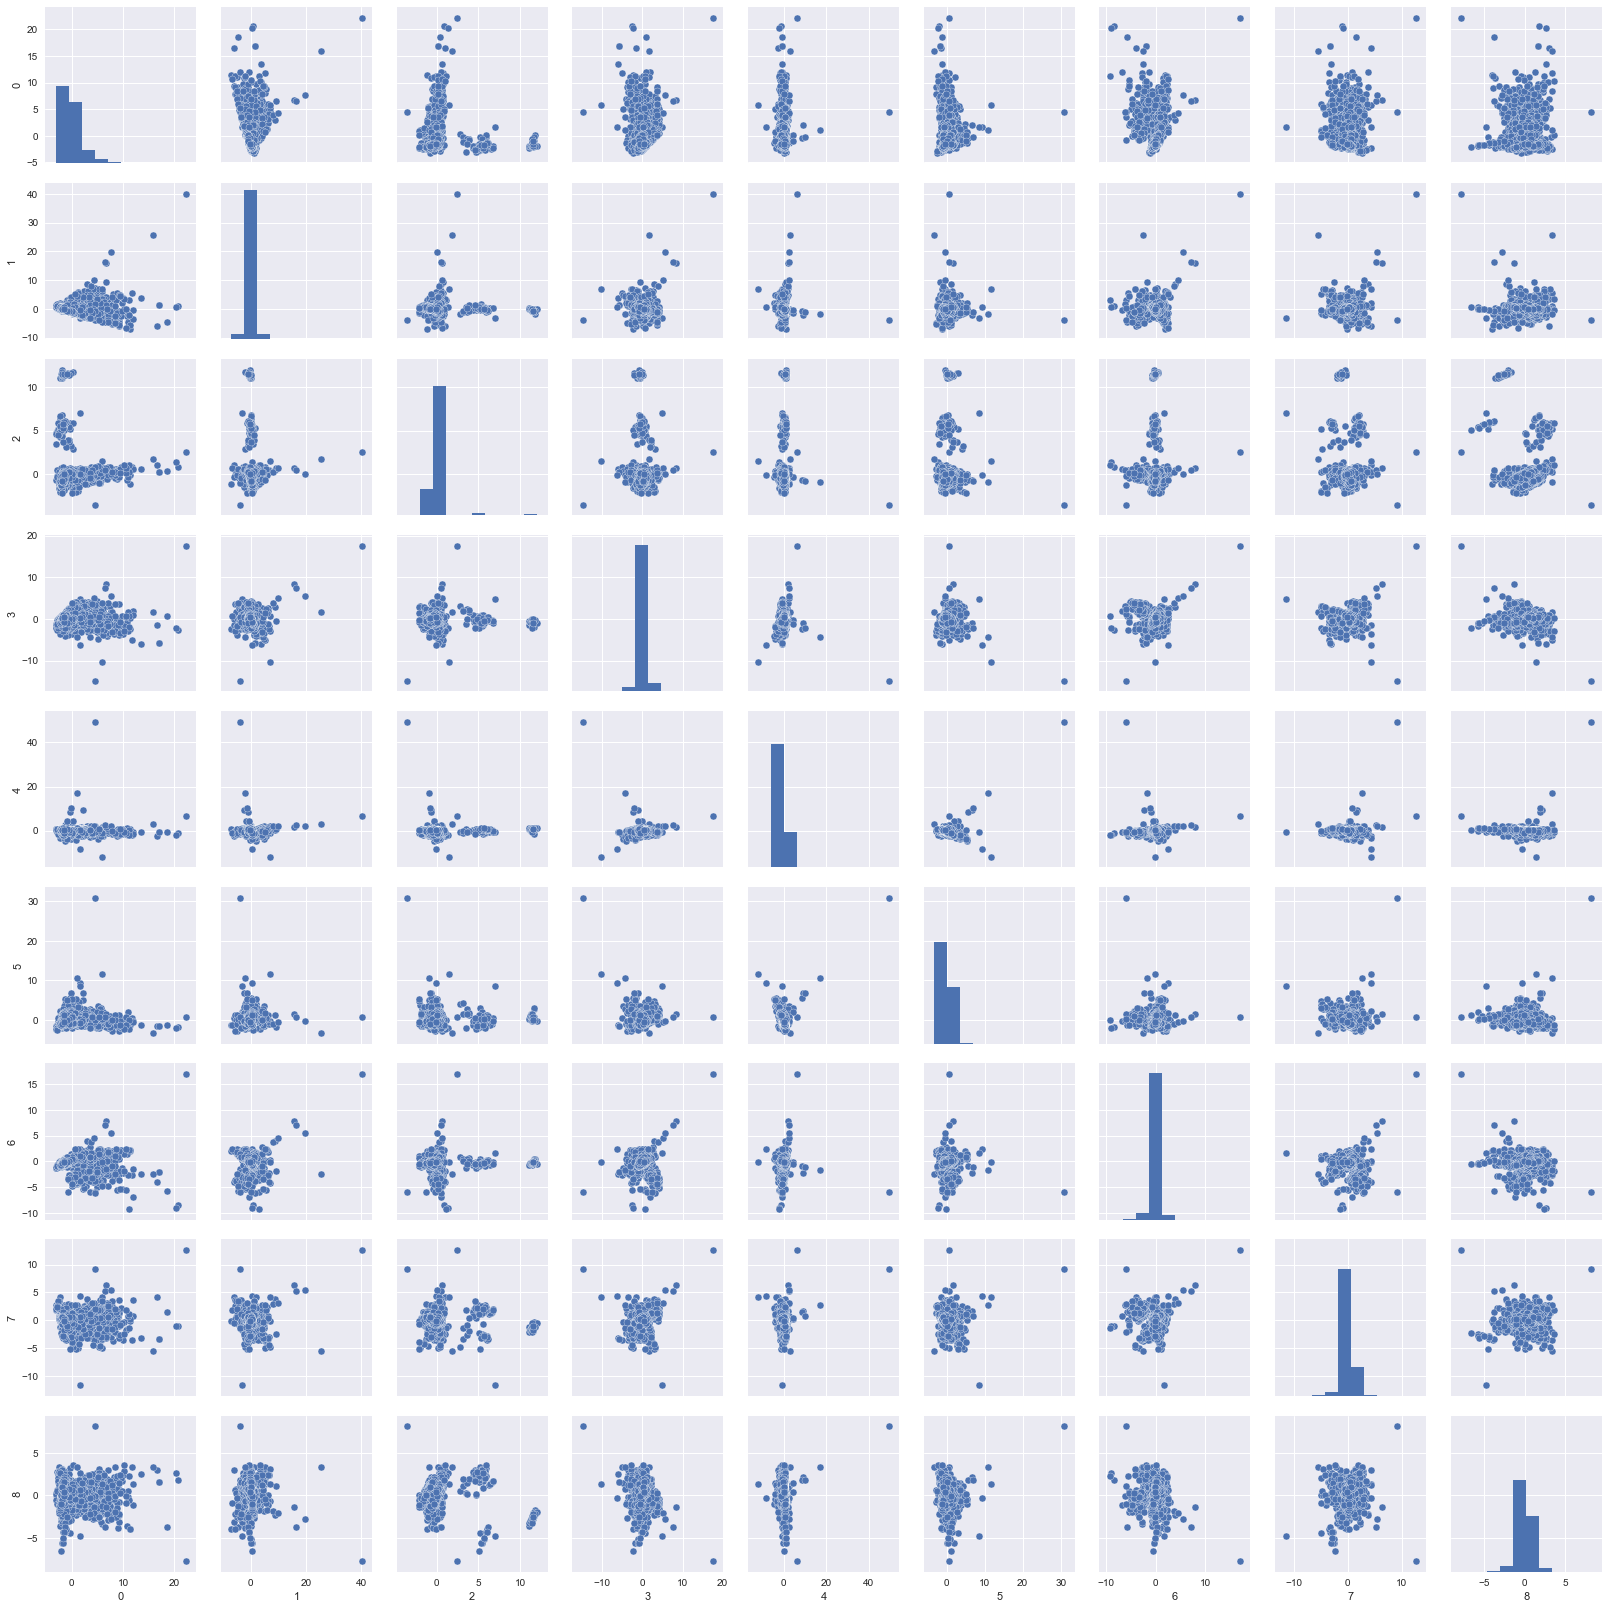

In [13]:
sns.pairplot(pd.DataFrame(data['PCA9']));

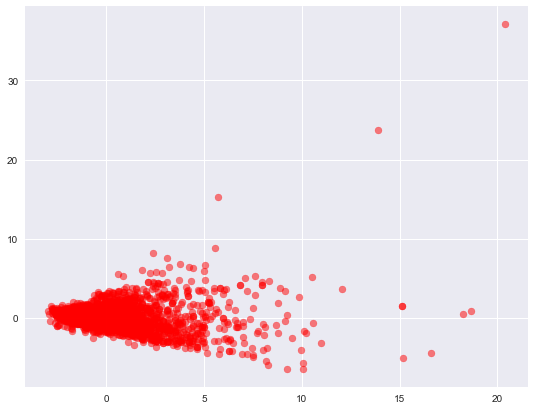

In [59]:
plt.figure(figsize = (9,7))
plt.scatter(data['PCA10'][:,0], data['PCA10'][:,1], c='red',alpha=0.5)
#plt.ylim(-10,30)
plt.show()

By ploting component 0 against 1 we cannot really see anything useful.

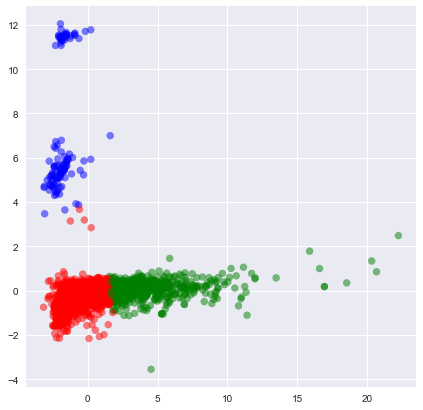

In [18]:
# Set a 3 KMeans clustering
kmeans = KMeans(n_clusters=3)
# Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(data['PCA9'])

# Define our own color map
LABEL_COLOR_MAP = {0 : 'r',1 : 'g',2 : 'b'}
label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

# Plot the scatter digram
plt.figure(figsize = (7,7))
plt.scatter(data['PCA9'][:,0],data['PCA9'][:,2], c= label_color, alpha=0.5) 
plt.show()

c:\users\chris\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
c:\users\chris\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


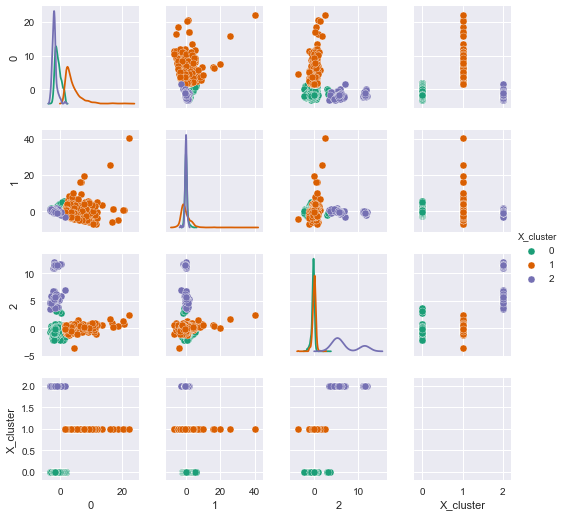

In [19]:
# Create a temp dataframe from our PCA projection data "x_9d"
df = pd.DataFrame(data['PCA9'])
df = df[[0,1,2]] # only want to visualise relationships between first 3 projections
df['X_cluster'] = X_clustered
sns.pairplot(df, hue='X_cluster', palette= 'Dark2', diag_kind='kde',size=1.85);

# 5. Interpret Results